In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tarp import get_tarp_coverage

First, we show how to use `get_tarp_coverage` (note that this function used to be called `get_drp_coverage` in a previous version)

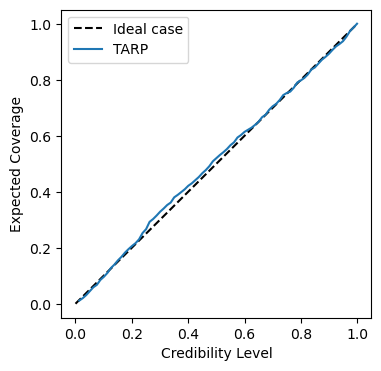

In [2]:
def generate_psd_matrix(n):
    # generate random array of appropriate size
    arr_size = int(n * (n - 1) / 2)
    arr = np.random.rand(arr_size)

    # convert array to symmetric matrix
    mat = np.zeros((n, n))
    triu_indices = np.triu_indices(n, k=1)
    mat[triu_indices] = arr
    mat += mat.T

    # check if matrix is positive semidefinite
    eigenvals = np.linalg.eigvalsh(mat)
    if np.all(eigenvals >= 0):
        return mat
    else:
        # if not, add identity matrix to make it PSD
        mat = mat + np.eye(n) * abs(eigenvals.min()) * 2
        return mat
    

def generate_correlated_samples(num_samples, num_sims, num_dims):
    """ Generate samples and true parameter values """
    theta = np.random.uniform(low=-5, high=5, size=(num_sims, num_dims))
    cov = [generate_psd_matrix(num_dims) for _ in range(num_sims)]
    cov = np.concatenate(cov).reshape(num_sims, num_dims, num_dims)
    samples = [np.random.multivariate_normal(mean=theta[i], cov=cov[i], size=num_samples) for i in range(num_sims)]
    samples = np.stack(samples)
    samples = samples.transpose(1, 0, 2)
    theta = [np.random.multivariate_normal(mean=theta[i], cov=cov[i], size=1) for i in range(num_sims)]
    theta = np.stack(theta)[:,0]
    return samples, theta


""" Main function """
samples, theta = generate_correlated_samples(num_samples=1000, num_sims=800, num_dims=10) # You can decrease the number of simulations for faster computation
ecp, alpha = get_tarp_coverage(samples, theta, references='random', metric='euclidean', norm = True, seed = 5)

fig, ax = plt.subplots(1, 1, figsize=(4, 4))

ax.plot([0, 1], [0, 1], ls='--', color='k', label = "Ideal case")
ax.plot(alpha, ecp, label='TARP')
ax.legend()
ax.set_ylabel("Expected Coverage")
ax.set_xlabel("Credibility Level")

plt.subplots_adjust(wspace=0.4)

### Test bootstrapping:

The new `bootstrapping` function is now implemented for `get_tarp_coverage`. This provides a method to offset the unpredictability of each tarp test. The function `get_tarp_coverage` now has a new argument `bootstrap` which is set to `False` by default. If set to `True`, the function will return the bootstrapped coverage for each credibility level. The function will return a 2D array of shape `(num_bootstraps, num_alpha)` where `num_alpha` is the number of credibility levels. The mean and standard deviation of the bootstrapped coverage can be computed using `ecp_bootstrap.mean(axis=0)` and `ecp_bootstrap.std(axis=0)` respectively.

In [3]:
# This might take some time...
ecp_bootstrap, alpha_bootstrap = get_tarp_coverage(samples, theta, references = "random", metric = "euclidean", norm = True, bootstrap=True)

100%|██████████| 800/800 [00:36<00:00, 22.19it/s]


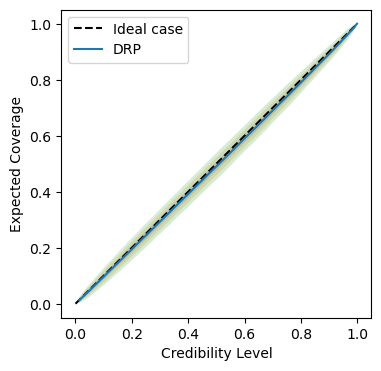

In [4]:
k_sigma = [1, 2, 3]

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.plot([0, 1], [0, 1], ls='--', color='k', label = "Ideal case")
ax.plot(alpha, ecp_bootstrap.mean(axis=0), label='DRP')
for k in k_sigma:
    ax.fill_between(alpha, ecp_bootstrap.mean(axis=0) - k * ecp_bootstrap.std(axis=0), ecp_bootstrap.mean(axis=0) + k * ecp_bootstrap.std(axis=0), alpha = 0.2)
ax.legend()
ax.set_ylabel("Expected Coverage")
ax.set_xlabel("Credibility Level")
plt.show()